In [1]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

$$\begin{align*}
    \dot{Y} &= \mu_{\text{max}} \frac{S}{K_s + S}Y \\
    \dot{S} &= -\frac{1}{Y_{X/S}} \dot{Y} \\
    \dot{P} &= Y_{P/S} (-\dot{S})
\end{align*}$$

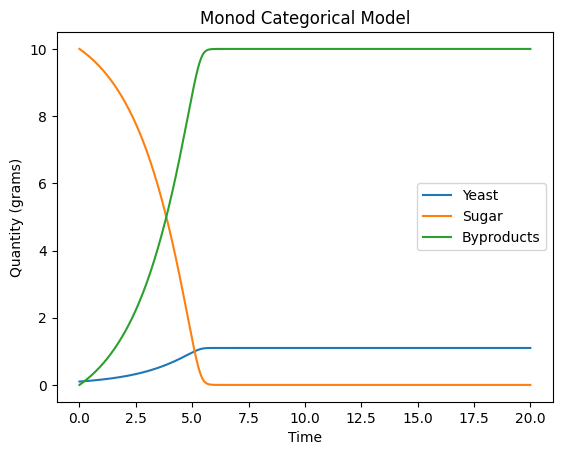

In [14]:
def ode(t, y, mu, K, Yxs, Yps):
    """Categorical model for yeast growth with three categories: yeast, sugar, and byproducts.
    Uses the monod equation for yeast growth.
    """
    return np.array([
        mu * (y[1] / (K + y[1])) * y[0],
        -(1 / Yxs) * mu * (y[1] / (K + y[1])) * y[0],
        (Yps / Yxs) * mu * (y[1] / (K + y[1])) * y[0]
    ])

# Building inputs
t0 = 0
tf = 20
t_span = (t0, tf)
y0 = np.array([0.1, 10, 0])  # g/L
t = np.linspace(t0, tf, 1000)

# Parameters
mu = 0.5  # Maximum growth rate of yeast
K = 0.6    # Half-velocity constant
Yxs = 0.1  # Biomass per g sugar
Yps = 1  # Product yield

sol = solve_ivp(ode, t_span, y0, t_eval=t,
                args=(mu, K, Yxs, Yps))

plt.plot(sol.t, sol.y[0], label="Yeast")
plt.plot(sol.t, sol.y[1], label="Sugar")
plt.plot(sol.t, sol.y[2], label="Byproducts")

plt.xlabel("Time")
plt.ylabel("Quantity (grams)")
plt.title("Monod Categorical Model")
plt.legend()

plt.show()